In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, fisher_exact
import operator
from core_functions import *
from statsmodels.stats.multitest import multipletests
import random 
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from venn import venn


plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'

data_path = '../../data/'
SCdata_path = data_path+'scRNAseqdata/'

# Data load

In [34]:
SC = pd.read_excel(data_path+'Table S1.xlsx',sheet_name='H')
TCR =  pd.read_excel(data_path+'Table S1.xlsx',sheet_name='I')
expan = 'Expanded TCR'
single = 'Singleton TCR'
non = 'Non-TCR'

In [8]:
impop_colors = {
    'Cyt cells proliferating':'#be3372',    
    'Cyt cells [>>Tcell]':'#fa7fe5',    
    'Cyt cells [>>NK]':'#6a1497',    
    'Treg':'#9555ed',
    'Naive Tcells':'#74cded'
}

# TCR clonotype type proportions

### Per cell cluster

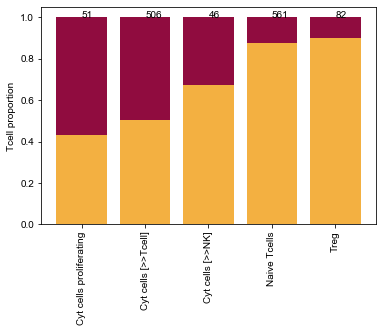

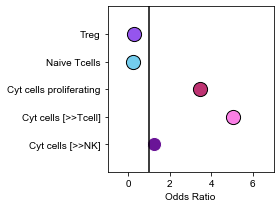

In [9]:
x = 0
allts = len(SC[SC['TCR clonotype class'].isin([expan,single])])
allexp = len(SC[SC['TCR clonotype class'].isin([expan])])
allnexp = len(SC[SC['TCR clonotype class'].isin([single])])
samples = []
fig, ax = plt.subplots()
oddsd = {}
oddspvald = {}
clusters_selected = ['Cyt cells proliferating','Cyt cells [>>Tcell]','Cyt cells [>>NK]','Naive Tcells','Treg'] 
SC_selection = SC[SC['cluster_cell_class'].isin(clusters_selected)]
for sample in clusters_selected:
    sampledf = SC[SC['cluster_cell_class']==sample]
    withTCR = sampledf[sampledf['TCR clonotype class'].isin([expan,single])]
    sing = sampledf[sampledf['TCR clonotype class']==single]
    exp =  sampledf[sampledf['TCR clonotype class']==expan]
    plt.bar(x,len(sing)/float(len(withTCR)),bottom=0,color='#F3B041')
    plt.bar(x,len(exp)/float(len(withTCR)),bottom=len(sing)/float(len(withTCR)),color='#900C3F')
    plt.text(x,1,len(withTCR))
    x+=1
    samples.append(sample)

    exp = sampledf[sampledf['TCR clonotype class']==expan]
    nexp = sampledf[sampledf['TCR clonotype class']==single]
    notcell = sampledf[sampledf['TCR clonotype class']==non]
    tcell = len(sampledf)-len(sampledf)
    
    a = len(exp)
    b = len(nexp)
    c = allexp-a
    d = allnexp-b
    
    table = [[a,b],
             [c,d]]
    odds,pval = fisher_exact(table)
    oddsd[sample] = odds
    oddspvald[sample] = pval    
    
    
plt.xticks(range(0,x),clusters_selected,rotation=90)
plt.ylabel('Tcell proportion')
plt.xticks(rotation=90)
plt.show()


fig,ax = plt.subplots(figsize=(4,3))
for i,k in enumerate(sorted(oddsd.keys())):
    if oddspvald[k] < 0.05:
        edg = 'black'
    else:
        edg = 'white'
    plt.scatter(oddsd[k],i,s=200,color=impop_colors[k],edgecolors=edg)

plt.yticks(range(0,len(oddsd)),sorted(oddsd.keys()))
plt.vlines(x=1,ymin=-1,ymax=5)
plt.xlabel('Odds Ratio')
plt.xlim(-1,7)
plt.ylim(-1,5)
plt.tight_layout()
plt.show()

### Per sample

In [3]:
SC['Sample ID'] = SC['Patient ID']+'_'+SC['Sample type']

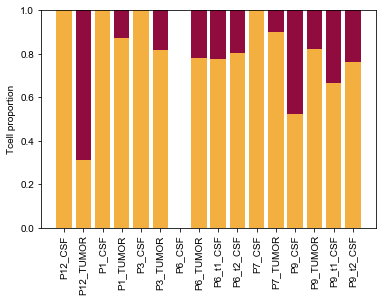

In [25]:
x = 0
labels = []
for sample, sampledf in SC.groupby('Sample ID'):
    withTCR = sampledf[sampledf['TCR clonotype class'].isin([expan,single])]
    if len(withTCR) > 0:
        sing = sampledf[sampledf['TCR clonotype class']==single]
        exp =  sampledf[sampledf['TCR clonotype class']==expan]
        plt.bar(x,len(sing)/float(len(withTCR)),bottom=0,color='#F3B041')
        plt.bar(x,len(exp)/float(len(withTCR)),bottom=len(sing)/float(len(withTCR)),color='#900C3F')
    else:
        plt.bar(x,0)
    x+=1
    labels.append(sample)
plt.xticks(range(0,len(labels)),labels,rotation=90)
plt.ylabel('Tcell proportion')
plt.show()

# TCR clonotypes count plots

In [30]:
print(len(TCR['TCR sequence'].unique()),len(TCR['Cell ID'].unique()))
allclonstemps = Counter([c for t in TCR['TCR sequence'].tolist() for c in t.split(';')])
print(len(allclonstemps),len([k for k,v in dict(allclonstemps).items() if v ==1]),len([k for k,v in dict(allclonstemps).items() if v >1]))

1332 1729
2082 1813 269


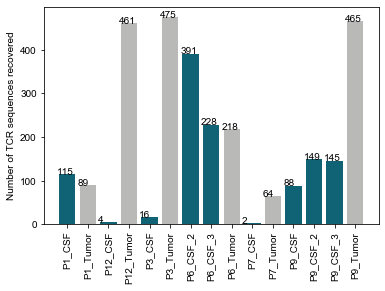

In [54]:
sampletype_colors = {
    'Tumor':'#b9b9b8',
    'CSF':'#0f6375',
    'CSF_2':'#0f6375',
    'CSF_3':'#0f6375',
}
seqs = {}
seqs_s = {}
xticks = []
x = 0
for s, sampledf in TCR.groupby('Patient ID'):
    if s not in seqs_s:
        seqs_s[s] = {}
        seqs[s] = {}

    for sampletype, sampletypedf in sampledf.groupby('Sample type'):        
        #$seqs[sample][sampletype] = [clon for row in sampledf.to_dict(orient='records') for clon in row['Clono_id'].split(';') if clon !='No clonotype']
        seqs[s][sampletype] = [s for row in sampletypedf.to_dict(orient='records') 
                               for s in row['TCR sequence'].split(';') 
                               if row['TCR sequence'] !='No clonotype' ]        
        seqs_s[s][sampletype] = set(seqs[s][sampletype])
        xticks.append(s+'_'+sampletype)
        plt.bar(x,len(seqs[s][sampletype]),color=sampletype_colors[sampletype])
        plt.text(x-0.5,len(seqs[s][sampletype]),s=str(len(seqs[s][sampletype])))
        x+=1
plt.xticks(range(0,len(xticks)),xticks,rotation=90)
plt.ylabel('Number of TCR sequences recovered')
plt.show()

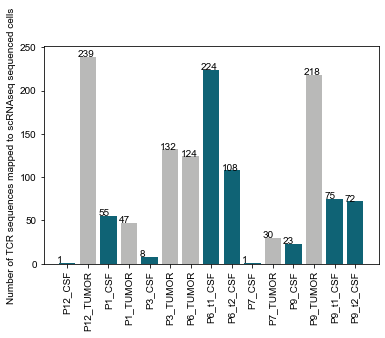

In [52]:
xticks = []
x = 0
SC['Sample ID'] = SC['Patient ID']+'_'+SC['Sample type']
SCtcr = SC[SC['TCR clonotype class'].isin([single,expan])]
for s, sampledf in SCtcr.groupby('Sample ID'):
    typ = sampledf['Sample type'].values[0]
    plt.bar(x,len(sampledf['Cell ID'].unique()),color=sampletype_colors[typ])
    plt.text(x-0.5,len(sampledf['Cell ID'].unique()),s=str(len(sampledf['Cell ID'].unique())))
    x+=1
    xticks.append(s)
plt.xticks(range(0,len(xticks)),xticks,rotation=90)
plt.ylabel('Number of TCR sequences mapped to scRNAseq sequenced cells')
plt.show()

In [51]:
clons_freqs = pd.DataFrame()
for samp,seqd in seqs.items():
    for typ,seql in seqd.items():
        df = pd.DataFrame(list(dict(Counter(seql)).items()),columns = ['Clono_id','Clono_count'])
        sing = df[df['Clono_count']==1]
        exp =  df[df['Clono_count']>1]
        df_expan = df[df['Clono_count']>1]
        df_expan['Cell_total'] = df_expan['Clono_count'].sum()
        df_expan['SAMPLE'] = samp
        df_expan['SAMPLE_TYPE'] = typ
        clons_freqs = clons_freqs.append(df_expan)

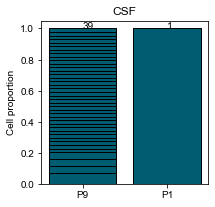

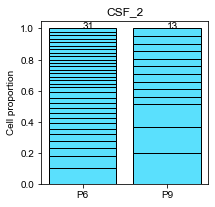

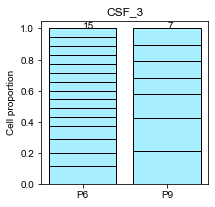

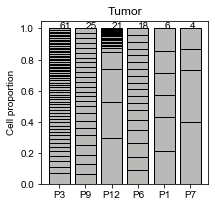

In [56]:
colors = {'Tumor':'#B9B9B8','CSF':'#005C70','CSF_2':'#00cffda5','CSF_3':'#a8efffff'}

for sampletype, sampletypedf in clons_freqs.groupby('SAMPLE_TYPE'):

    clons_freqsT = clons_freqs[clons_freqs['SAMPLE_TYPE']==sampletype]
    y = 0
    labels = []
    clonodiff = {sample:len(sampledf) for sample, sampledf in clons_freqsT.groupby('SAMPLE')}
    clonodiff_s = [k for k, v in sorted(clonodiff.items(), key=lambda item: item[1],reverse=True)]
    fig,ax = plt.subplots(figsize=(3,3))
    for sample in clonodiff_s:
        sampledf = clons_freqsT[clons_freqsT['SAMPLE']==sample].sort_values(by='Clono_count',ascending=False)
        count = 0
        for row in sampledf.to_dict(orient='records'):
            plt.bar(y,row['Clono_count']/float(row['Cell_total']),bottom=count,color=colors[sampletype],linewidth=1,edgecolor='black')
            count += row['Clono_count']/float(row['Cell_total'])
        plt.text(y,1,str(clonodiff[sample]))
        y+=1
        labels.append(sample)
    plt.xticks(range(0,len(labels)),labels)
    plt.title(sampletype)
    plt.ylabel('Cell proportion')
    plt.show()
    

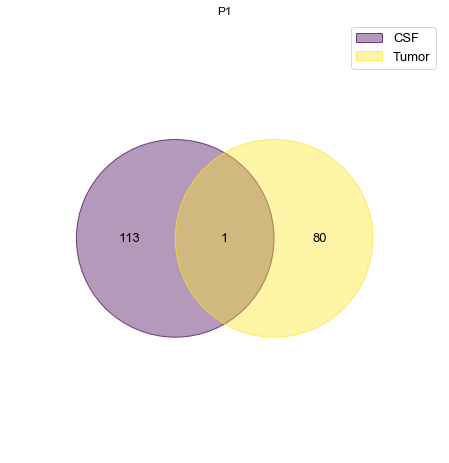

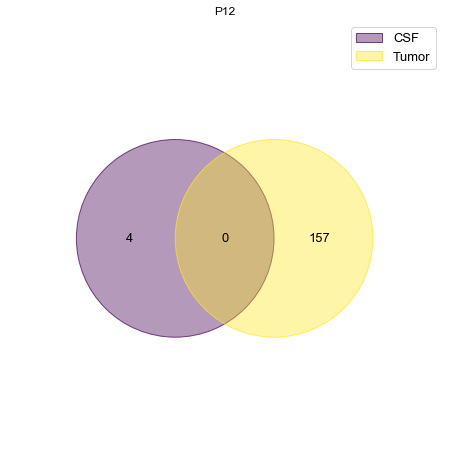

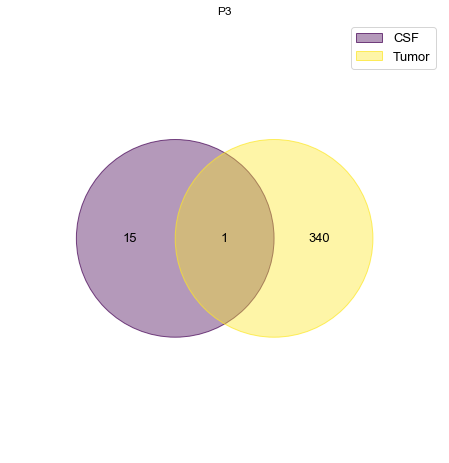

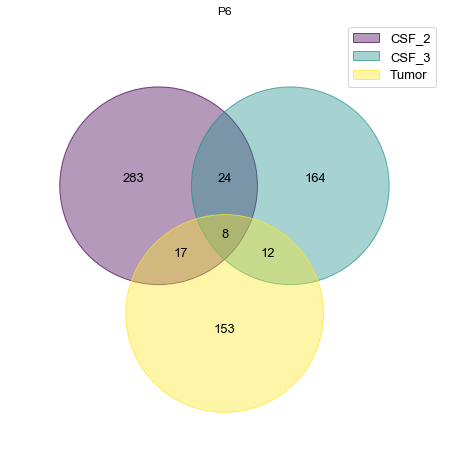

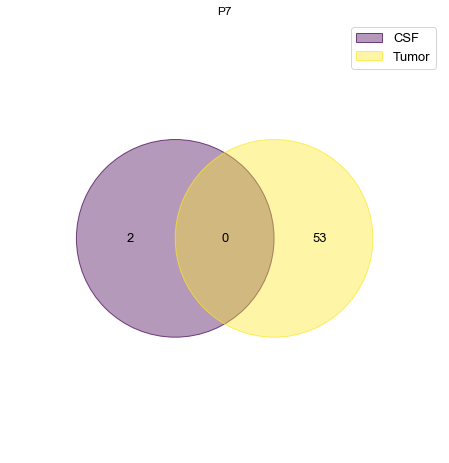

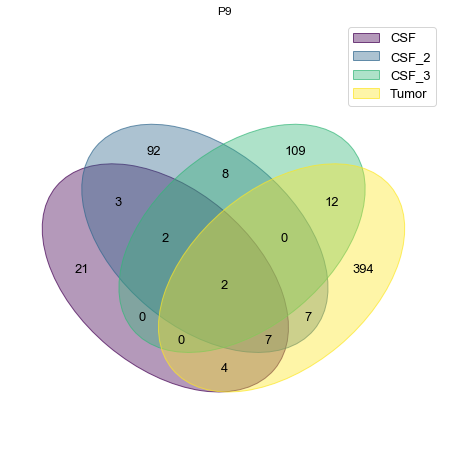

In [60]:
for s in seqs_s.keys():
    venn(seqs_s[s])
    plt.title(s)
    plt.show()

### Generate table for fishplot

In [64]:
for sample,timedf in seqs.items():
    if sample in ['P6','P9']:
        df = pd.DataFrame()
        if 'CSF' in seqs_s[sample]:
            allclons = list(seqs[sample]['CSF']) + list(seqs[sample]['CSF_2']) + list(seqs[sample]['CSF_3'])
        else:
            allclons = list(seqs[sample]['CSF_2']) + list(seqs[sample]['CSF_3'])
            
        allclonscount = dict(Counter(allclons))
        allexp = [clon for clon,v in allclonscount.items() if v > 1]
                                             
        d = {typ:[] for typ in timedf.keys()}
        for typ,clonlist in timedf.items():
            clonstoconsider = set(clonlist).intersection(set(allexp))
            print(sample,typ,len(clonstoconsider))
            clonstoconsidercounts = Counter([s for s in clonlist if s in clonstoconsider])
            for clon in set(allexp):
                if clon in clonstoconsidercounts:
                    d[typ].append((clonstoconsidercounts[clon]/float(sum(clonstoconsidercounts.values()))*100)-0.0000001)
                else:
                    d[typ].append(0)                                  
        df = pd.DataFrame(d)      
        if sample == 'P6':
            df[['CSF_2','CSF_3']].to_csv('../../tmp/'+sample+'_TCRseqs_toFISH.tsv',sep='\t',index=False)
        else:
            df[['CSF','CSF_2','CSF_3']].to_csv('../../tmp/'+sample+'_TCRseqs_toFISH.tsv',sep='\t',index=False)

P6 CSF_2 50
P6 CSF_3 38
P6 Tumor 15
P9 CSF 39
P9 CSF_2 28
P9 CSF_3 15
P9 Tumor 17


# Tcell gene markers

In [ ]:
cell_exp_selection = raw_exp[raw_exp.index.isin(SC_selection['Cell ID'].tolist())]
markersdata = pd.read_csv(data_path+'reference_markers.tsv',sep='\t',index_col=False)
markers = {subset:subsetdf.marker.tolist() for subset,subsetdf in markersdata.groupby('subset_name')}
markers_label = {subset:subsetdf.fillna('').cell_type_plot.tolist() for subset,subsetdf in markersdata.groupby('subset_name')}

cell_exp_selectionZ = pd.DataFrame()
for c in cell_exp_selection.columns.tolist():
    if sum(cell_exp_selection[c]) > 0:
        cell_exp_selectionZ[c] = cell_exp_selection[c]
cell_exp_selectionZ = cell_exp_selectionZ.set_index(cell_exp_selection.index)

genes_of_interest = {
    'CDKS':['CDKN1B','CDKN1A','MKI67'],
    'Cytotoxicity':['CD8A','CD8B','GZMA','GZMB','PRF1','ENTPD1','IFNG'],
    'Exhaustion':['TIGIT','CTLA4','ICOS','PDCD1','LAG3','TIM3'],
    'Treg':['FOXP3','CTLA4','IL2RA'],
    'Naive':['SELL','CCR7','LEF1','TCF7','IL7R'],
    'Memory':['CD44','CD69','CD27'],
    'NK':['NKG7','GNLY','KLRC1','KLRD1','KIR2DL4','KLRB1']
}
allgenes = sum(list(genes_of_interest.values()),[])
cell_exp_selectionZ_geneselection = cell_exp_selectionZ[cell_exp_selectionZ.index.isin(allgenes)]
map_names = {row['level_0']:row['index'] for row in cell_exp_selectionZ_geneselection.T.reset_index().reset_index().to_dict(orient='records')}
cluster_colors = {row['cluster_cell_class']:row['color'] for row in allcluster_annotations.to_dict(orient='records')}

gen_means = []
geneset_means = []
indexl = []
for cluster, cells in clusters_cells.items():
    cell_exp_selectionZ_geneselection_cluster = cell_exp_selectionZ_geneselection[cells]
    d = {}
    d2 = {}
    for geneset, genes in genes_of_interest.items():
        for gene in genes:
            if gene in cell_exp_selectionZ_geneselection_cluster.index:
                #gen_means[cluster][gene] = np.mean(cell_exp_selectionZ_geneselection_cluster.T[gene])
                d[gene] = np.mean(cell_exp_selectionZ_geneselection_cluster.T[gene])
        d2[geneset] =  np.mean(list(d.values()))
    gen_means.append(d)
    geneset_means.append(d2)
    indexl.append(cluster)
gen_meansdf = pd.DataFrame(gen_means)
gen_meansdf.index = indexl
gen_meansdf = gen_meansdf.T#[['Cyt cells [Tcell em+NK]','Cyt cells [Tcell CD8 em+NK]', 'Cyt cells [Tcell CD8 em+NK] prolif', 'Naïve Tcells', 'T cell exhausted + Treg']]
gens_geneset = {gene:geneset for geneset, genes in genes_of_interest.items() for gene in genes}

geneset_meansdf = pd.DataFrame(geneset_means)
geneset_meansdf.index = indexl
geneset_meansdf = geneset_meansdf.T#[['Cyt cells [Tcell em+NK]','Cyt cells [Tcell CD8 em+NK]', 'Cyt cells [Tcell CD8 em+NK] prolif', 'Naïve Tcells', 'T cell exhausted + Treg']]

absFC = []
for row in geneset_meansdf.to_dict(orient='records'):
    v = []
    for c in geneset_meansdf.columns:
        fc = row[c]/float(np.mean([row[c2] for c2 in geneset_meansdf.columns if c2!=c]))
        v.append(fc)
    absFC.append(v)
absFCdf = pd.DataFrame(absFC)
absFCdf.index = geneset_meansdf.index
absFCdf.columns = geneset_meansdf.columns

allgene_s = ['IL2RA','FOXP3','CTLA4','LAG3','PDCD1','ICOS','TIGIT','GZMA','GZMB','ENTPD1','PRF1','IFNG','CD8A','CD8B','MKI67']
sns.set(font_scale=0.7)
df = gen_meansdf[clusters_selected].reindex(allgene_s)
grid = sns.clustermap(df,
               cmap='Reds',
              figsize=(3,4),
              col_cluster=False,
            row_cluster=False,
                xticklabels=False,
                      yticklabels=True,
              linewidths=1, vmin=0, vmax=1,  mask=(df==0))
plt.show()

# Clone network

In [54]:
import scirpy as ir
import pandas as pd
import numpy as np
import scanpy as sc
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy as sp
import anndata
import os
import re

sc.logging.print_versions()


scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.0


In [53]:
files = []
#Get all files under TableS3 folder
for r, d, f in os.walk(data_path+'TableS3'):
    for file in f:
        if 'filtered_contig_annotations.csv' in file:
            files.append(os.path.join(r, file))

#Load each TCR file. Add suffix for merging all info
values = {"P3/Tumor": 0, "P1/Tumor": 1, "P7/Tumor": 2, "P6/Tumor": 3, "P9/Tumor": 4, "P12/Tumor": 5, "P3/CSF": 6, "P1/CSF": 7, "P7/CSF": 8, "P6/2CSF": 9, "P6/3CSF": 10, "P9/CSF": 11, 
          "P9/2CSF": 12, "P9/3CSF": 13, "P12/CSF": 14}
          
TCR_files_list = []

for elem in files:
    #Load TCR file
    TCR_file = ir.io.read_10x_vdj(elem)
    #Reindex manually each anndata
    id = "/".join(re.split("/|_",elem)[-5:-3])
    #print(values[id])
    index_aux = TCR_file.obs.index.to_numpy()
    index_aux2 = [x+'-'+str(values[id]) for x in index_aux]
    index_aux2
    TCR_file.obs['cell_id'] = index_aux2
    TCR_file.obs.set_index('cell_id',inplace=True)
    TCR_files_list.append(TCR_file.obs)
    
aux = pd.concat(TCR_files_list)
aux



... storing 'TRA_1_cdr3' as categorical
... storing 'TRA_2_cdr3' as categorical
... storing 'TRB_1_cdr3' as categorical
... storing 'TRB_2_cdr3' as categorical
... storing 'TRA_1_junction_ins' as categorical
... storing 'TRA_2_junction_ins' as categorical
... storing 'TRB_1_junction_ins' as categorical
... storing 'TRB_2_junction_ins' as categorical
... storing 'TRB_2_expr' as categorical
... storing 'TRA_1_v_gene' as categorical
... storing 'TRA_2_v_gene' as categorical
... storing 'TRB_1_v_gene' as categorical
... storing 'TRB_2_v_gene' as categorical
... storing 'TRA_1_d_gene' as categorical
... storing 'TRA_2_d_gene' as categorical
... storing 'TRB_1_d_gene' as categorical
... storing 'TRB_2_d_gene' as categorical
... storing 'TRA_1_j_gene' as categorical
... storing 'TRA_2_j_gene' as categorical
... storing 'TRB_1_j_gene' as categorical
... storing 'TRB_2_j_gene' as categorical
... storing 'TRA_1_c_gene' as categorical
... storing 'TRA_2_c_gene' as categorical
... storing 'TRB_1_c

multi_chain       TRA_1_cdr3       TRA_2_cdr3  \
cell_id                                                                
AACTCTTGTGTGAATA-1-13        False             None             None   
AACTTTCTCAAGGTAA-1-13        False  CVVFDSGAGSYQLTF             None   
AAGGAGCTCTTCTGGC-1-13        False             None             None   
AAGGCAGAGTGTCCCG-1-13        False             None             None   
ACTGATGAGAGTACAT-1-13        False     CAVPQGANNLFF             None   
...                            ...              ...              ...   
TGGGAAGAGGACTGGT-1-12        False    CAMRVGGYNKLIF             None   
TTCTCCTCATCAGTAC-1-12        False   CAVNLDTGRRALTF             None   
TTCTTAGCACGAAATA-1-12        False    CAVRDNNNARLMF  CVVSAIPHGNNRLAF   
TTGTAGGAGATGTGGC-1-12        False             None             None   
TTTACTGGTCCGTCAG-1-12        False    CAGPHRNTDKLIF             None   

                               TRB_1_cdr3 TRB_2_cdr3 TRA_1_junction_ins  \
cell_id                                                                   
AACTCTTGTGTGAATA-1-13        CSARDGGSPLHF       None               None   
AACTTTCTCAAGGTAA-1-13       CASSLENRYEQYF       None               None   
AAGGAGCTCTTCTGGC-1-13  CSARETIWTSGTYNEQFF       None               None   
AAGGCAGAGTGTCCCG-1-13      CSVEGRGALYGYTF       None               None   
ACTGATGAGAGTACAT-1-13     CASSLTGQGNYEQYF       None               None   
...                                   ...        ...                ...   
TGGGAAGAGGACTGGT-1-12  CASSLFQGITGLTGELFF       None               None   
TTCTCCTCATCAGTAC-1-12      CATRPEGGFNEQFF       None               None   
TTCTTAGCACGAAATA-1-12     CASSRSGTGANVLTF       None               None   
TTGTAGGAGATGTGGC-1-12       CASSLQNSYEQYF       None               None   
TTTACTGGTCCGTCAG-1-12  CSVFELTGLELIGTEAFF       None               None   

                      TRA_2_junction_ins TRB_1_junction_ins  \
cell_id                                                       
AACTCTTGTGTGAATA-1-13               None               None   
AACTTTCTCAAGGTAA-1-13               None               None   
AAGGAGCTCTTCTGGC-1-13               None               None   
AAGGCAGAGTGTCCCG-1-13               None               None   
ACTGATGAGAGTACAT-1-13               None               None   
...                                  ...                ...   
TGGGAAGAGGACTGGT-1-12               None               None   
TTCTCCTCATCAGTAC-1-12               None               None   
TTCTTAGCACGAAATA-1-12               None               None   
TTGTAGGAGATGTGGC-1-12               None               None   
TTTACTGGTCCGTCAG-1-12               None               None   

                      TRB_2_junction_ins  TRA_1_expr  ... TRB_2_j_gene  \
cell_id                                               ...                
AACTCTTGTGTGAATA-1-13               None         NaN  ...         None   
AACTTTCTCAAGGTAA-1-13               None         1.0  ...         None   
AAGGAGCTCTTCTGGC-1-13               None         NaN  ...         None   
AAGGCAGAGTGTCCCG-1-13               None         NaN  ...         None   
ACTGATGAGAGTACAT-1-13               None         3.0  ...         None   
...                                  ...         ...  ...          ...   
TGGGAAGAGGACTGGT-1-12               None         1.0  ...         None   
TTCTCCTCATCAGTAC-1-12               None         7.0  ...         None   
TTCTTAGCACGAAATA-1-12               None        17.0  ...         None   
TTGTAGGAGATGTGGC-1-12               None         NaN  ...         None   
TTTACTGGTCCGTCAG-1-12               None         3.0  ...         None   

                       TRA_1_c_gene TRA_2_c_gene TRB_1_c_gene TRB_2_c_gene  \
cell_id                                                                      
AACTCTTGTGTGAATA-1-13          None         None        TRBC1         None   
AACTTTCTCAAGGTAA-1-13          TRAC         None        TRBC2         None   
AAGGAGCTCTTCTGG

In [8]:
#Create an Anndata with the previous info
X = pd.DataFrame(np.empty((len(aux.index),1)))
obs = aux
adata_TCR_all_copy = anndata.AnnData(X=X, obs=obs)

#Load the metadata info for the cells
metadata = pd.read_csv(data_path+'metadata_info.tsv', sep="\t", index_col=0)

files = []
#Get all files under TableS2 folder
for r, d, f in os.walk(data_path+'TableS2'):
    for file in d:
        if 'filtered_feature_bc_matrix' in file:
            files.append(os.path.join(r, file))

cDNA_files_list = []

for elem in files:
    print(elem)
    #Load cDNA file
    cDNA_file = sc.read_10x_mtx(elem)
    cDNA_files_list.append(TCR_file.obs)
    
adata_all = pd.concat(cDNA_files_list)
adata_all

sc.pp.filter_genes(adata_all, min_cells=3)
sc.pp.normalize_total(adata_all, target_sum=1000)
sc.pp.log1p(adata_all)

#Take only the cells that are in the metadata file
adata_filtered = adata_all[metadata.index].copy()

#Merge the cDNA with TCR
ir.pp.merge_with_tcr(adata_filtered, adata_TCR_all_copy) 

#Copy the info from the metadata file
adata_filtered.obs["sample"] = metadata["sample"]
adata_filtered.obs["sample2"] = metadata["sample2"]
adata_filtered.obs["type"] = metadata["type"]
adata_filtered.obs["type2"] = metadata["type2"]
adata_filtered.obs["cluster"] = metadata["cluster"]
adata_filtered.obs["cluster_Tcells"] = metadata["cluster_Tcells"]
adata_filtered.obs["cluster_Prolif"] = metadata["cluster_Prolif"]
adata_filtered.obsm["X_umap"] = metadata[['UMAP_1','UMAP_2']].to_numpy()

adata_filtered

/home/trincadojl/anaconda3/envs/python_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'multi_chain' as categorical
... storing 'TRA_1_cdr3' as categorical
... storing 'TRA_2_cdr3' as categorical
... storing 'TRB_1_cdr3' as categorical
... storing 'TRB_2_cdr3' as categorical
... storing 'TRA_1_junction_ins' as categorical
... storing 'TRA_2_junction_ins' as categorical
... storing 'TRB_1_junction_ins' as categorical
... storing 'TRB_2_junction_ins' as categorical
... storing 'TRA_2_expr' as categorical
... storing 'TRB_2_expr' as categorical
... storing 'TRA_1_v_gene' as categorical
... storing 'TRA_2_v_gene' as categorical
... storing 'TRB_1_v_gene' as categorical
... storing 'TRB_2_v_gene' as categorical
... storing 'TRA_1_d_gene' as categorical
... storing 'TRA_2_d_gene' as categorical
... storing 'TRB_1_d_gene' as categorical


AnnData object with n_obs × n_vars = 15811 × 20189
    obs: 'batch', 'multi_chain', 'TRA_1_cdr3', 'TRA_2_cdr3', 'TRB_1_cdr3', 'TRB_2_cdr3', 'TRA_1_junction_ins', 'TRA_2_junction_ins', 'TRB_1_junction_ins', 'TRB_2_junction_ins', 'TRA_1_expr', 'TRA_2_expr', 'TRB_1_expr', 'TRB_2_expr', 'TRA_1_v_gene', 'TRA_2_v_gene', 'TRB_1_v_gene', 'TRB_2_v_gene', 'TRA_1_d_gene', 'TRA_2_d_gene', 'TRB_1_d_gene', 'TRB_2_d_gene', 'TRA_1_j_gene', 'TRA_2_j_gene', 'TRB_1_j_gene', 'TRB_2_j_gene', 'TRA_1_c_gene', 'TRA_2_c_gene', 'TRB_1_c_gene', 'TRB_2_c_gene', 'TRA_1_cdr3_nt', 'TRA_2_cdr3_nt', 'TRB_1_cdr3_nt', 'TRB_2_cdr3_nt', 'has_tcr', 'sample', 'sample2', 'type', 'type2', 'cluster', 'cluster_Tcells', 'cluster_Prolif'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

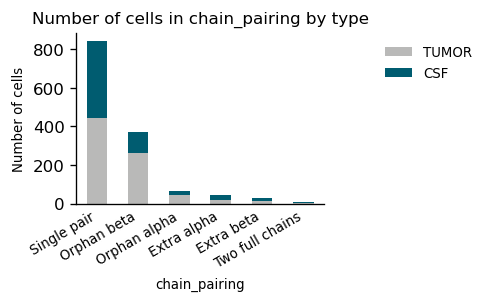

In [11]:
ir.tl.chain_pairing(adata_filtered)

#Remove the "no TCR" values from the plot
adata_filtered_aux = adata_filtered.copy()
adata_filtered_aux.obs[adata_filtered_aux.obs['chain_pairing'] == "No TCR"] = float("NaN")
adata_filtered_aux.obs

ir.pl.group_abundance(
    adata_filtered_aux, groupby="chain_pairing",target_col="type",color=['#B9B9B8', '#005C70']
)

100%|██████████| 14213/14213 [00:00<00:00, 125907.16it/s]
... storing 'clonotype' as categorical


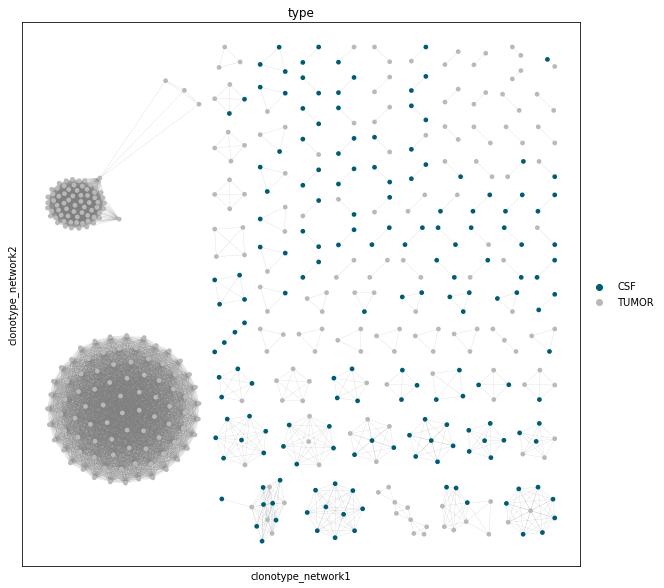

In [13]:
ir.pp.tcr_neighbors(adata_filtered, receptor_arms="any", dual_tcr="any", cutoff=0)
ir.tl.define_clonotypes(adata_filtered)
ir.tl.clonotype_network(adata_filtered, min_size=2)
from cycler import cycler
default_cycler = (cycler(color=['#005C70', '#B9B9B8']) + cycler(type=['CSF', 'Tumor']))
ir.pl.clonotype_network(adata_filtered, color="type", palette=default_cycler, legend_fontoutline=3, size=90, edges_width=0.1)
fig = mpl.pyplot.gcf()
fig.set_size_inches(10, 10)